In [34]:
# PCA
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

In [59]:
# read in file
dataset = pd.read_csv("Brain_GSE50161.csv")
dataset['type'] = dataset['type'].replace(['ependymoma', 'glioblastoma','medulloblastoma', 'pilocytic_astrocytoma','normal'],[0,1,2,3,4])
label = dataset.iloc[:,1]
original_features = dataset.iloc[:,2:]

In [60]:
# mean centering ((x-mean)/std)
# it is the same as standardization
original_features = np.array(original_features)
features = np.divide((original_features-original_features.mean(0)),original_features.std(0))

In [ ]:
# # Normalization:
# features = (original_features - np.min(original_features)) / (np.max(original_features) - np.min(original_features))

In [62]:
#PCA, Ensure that the data after dimensionality reduction maintains 99% of the information
scalar = StandardScaler()
scalar.fit(features)
scaled_data = scalar.transform(features)

pca = PCA(n_components=0.99)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

In [63]:
x_pca.shape

(130, 121)

In [64]:
from imblearn.over_sampling import SMOTE

In [65]:
#Split the data after PCA.
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(x_pca, label, test_size=1/3)

In [66]:
sm = SMOTE()
pca_x_train, pca_y_train = sm.fit_resample(pca_x_train, pca_y_train)

In [72]:
#Call the package for verification on the data after PCA.
model = KNeighborsClassifier()
model.fit(pca_x_train, pca_y_train)
pca_y_pred = model.predict(pca_x_test)
print('KNN accuracy after PCA: %.2f' % (metrics.accuracy_score(pca_y_pred, pca_y_test) * 100))
print('KNN F1 score after PCA: %.2f' % (metrics.f1_score(pca_y_pred, pca_y_test, average='macro') * 100))

KNN accuracy after PCA: 70.45
KNN F1 score after PCA: 74.20


In [73]:
model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(pca_x_train, pca_y_train)
pca_y_pred = model.predict(pca_x_test)
print('LogisticRegression accuracy after PCA: %.2f' % (metrics.accuracy_score(pca_y_pred, pca_y_test) * 100))
print('LogisticRegression F1 score after PCA: %.2f' % (metrics.f1_score(pca_y_pred, pca_y_test,average='macro') * 100))

LogisticRegression accuracy after PCA: 86.36
LogisticRegression F1 score after PCA: 87.48


In [74]:
nb = GaussianNB()
nb.fit(pca_x_train, pca_y_train)
pca_y_pred = nb.predict(pca_x_test)
print("Naive Bayes accuracy after PCA: %.2f" % (nb.score(pca_x_test, pca_y_test) * 100))
print('Naive Bayes F1 score after PCA: %.2f' % (metrics.f1_score(pca_y_pred, pca_y_test,average='macro') * 100))

Naive Bayes accuracy after PCA: 54.55
Naive Bayes F1 score after PCA: 48.76


In [75]:
#Random Forest
rf = RandomForestClassifier()
rf.fit(pca_x_train, pca_y_train)
pca_y_pred = rf.predict(pca_x_test)
print("Random Forest accuracy after PCA: %.2f" % (metrics.accuracy_score(pca_y_pred, pca_y_test) * 100))
print('Random Forest F1 score after PCA: %.2f' % (metrics.f1_score(pca_y_pred, pca_y_test,average='macro') * 100))

Random Forest accuracy after PCA: 77.27
Random Forest F1 score after PCA: 75.73


In [76]:
from imblearn.pipeline import Pipeline

In [78]:
#Check the 3-fold cross validation results on all models.
num_list1 = []
num_list2 = []
models = {
    'KNN 3-fold cross validation': KNeighborsClassifier(),
    'LogisticRegression 3-fold cross validation': LogisticRegression(solver='lbfgs', max_iter=2000),
    'Naive Bayes 3-fold cross validation': GaussianNB(),
    'Random Forest 3-fold cross validation': RandomForestClassifier(),
}
cv = KFold(n_splits=3, shuffle=True)

for name, model in models.items():
    steps = [('over', SMOTE()), ('model', model)]
    pipeline = Pipeline(steps=steps)
    scores = cross_val_score(pipeline, x_pca, label, cv = cv)
    f1_scores = cross_val_score(pipeline, x_pca, label, scoring="f1_macro",cv = cv)
    
    print('Accuracy value')
    print('%s: %.2f%%' % (name, np.mean(scores) * 100))
    print('F1 score')
    print('%s: %.2f%%' % (name, np.mean(f1_scores) * 100))
    num_list1.append('%.4f' % np.mean(scores))
    num_list2.append('%.4f' % np.mean(f1_scores))
# print(num_list1)
# print(num_list2)

Accuracy value
KNN 3-fold cross validation: 80.76%
F1 score
KNN 3-fold cross validation: 77.09%
Accuracy value
LogisticRegression 3-fold cross validation: 96.93%
F1 score
LogisticRegression 3-fold cross validation: 96.79%
Accuracy value
Naive Bayes 3-fold cross validation: 53.82%
F1 score
Naive Bayes 3-fold cross validation: 38.82%
Accuracy value
Random Forest 3-fold cross validation: 79.21%
F1 score
Random Forest 3-fold cross validation: 80.88%


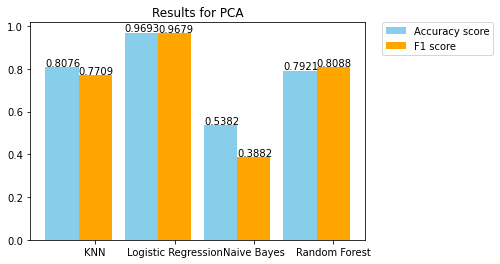

In [79]:
name_list = ['KNN', 'Logistic Regression','Naive Bayes','Random Forest']
num_list1 = list(map(float, num_list1))
num_list2 = list(map(float, num_list2))
x =list(range(len(num_list1)))
total_width, n = 0.92, 2.2
width = total_width / n

bars1 = plt.bar(x, num_list1, width=width, label='Accuracy score', fc = 'skyblue')
# bars1 = plt.bar(x, num_list1, width=width, label='3-fold', tick_label = name_list, fc = 'skyblue')
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
for i in range(len(x)):
    x[i] = x[i] + width
bars2 = plt.bar(x, num_list2, width=width, label='F1 score', tick_label = name_list,fc = 'orange')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
    
plt.title("Results for PCA")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()